In [1]:
# -*- coding: utf-8 -*-
import sys, os
import numpy as np
import pandas as pd
import cobra
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fontsize'] = 13
plt.rcParams.update({'mathtext.default': 'regular'})
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['savefig.bbox'] = 'tight'

print('Python version:', sys.version)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('cobrapy version:', cobra.__version__)

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.18.3
pandas version: 1.0.3
cobrapy version: 0.25.0


In [2]:
def KORxn(model: cobra.Model,
          rxns2KO: list):
    """Function for knocking out reactions."""
    for ID in rxns2KO:
        reaction = model.reactions.get_by_id(ID)
        reaction.knock_out()

In [3]:
def pfba(model: cobra.Model):
    cobra.flux_analysis.pfba(model)

In [4]:
def flux2file(model: cobra.Model, 
              psw, product, output_dir='tmp'):
    """Function of exporting flux data."""
    n = len(model.reactions)
    modelMatrix = np.empty([n, 9], dtype = object)
    for i in range(len(model.reactions)):
        x = model.reactions[i]
        modelMatrix[i, 0] = i + 1
        modelMatrix[i, 1] = x.id
        modelMatrix[i, 2] = x.name
        modelMatrix[i, 3] = x.reaction
        modelMatrix[i, 4] = x.subsystem
        modelMatrix[i, 5] = x.lower_bound
        modelMatrix[i, 6] = x.upper_bound
        modelMatrix[i, 7] = x.flux
        modelMatrix[i, 8] = abs(x.flux)
        
    df = pd.DataFrame(data = modelMatrix, 
                      columns = ['N', 'RxnID', 'RxnName', 'Reaction', 'SubSystem', 
                      'LowerBound', 'UpperBound', 'Flux-core', 'abs(Flux)'])
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    filepath = os.path.join(output_dir, '{}_{}.xlsx'.format(psw, product))
    df.to_excel(filepath, index=False)

 ## Model background

  * Using _E. coli_ full model iML1515.
  * Modified the transhydrogenase reaction (THD2pp) from 2 protons translocation to 1.
  * Changed HSDy (homoserine DH) to be irrversible, towards to homS.
  * Base deletions: PFL, OBTFL, POR5 (pyruvate synthase, Ferredoxin), FDH4pp, FDH5pp, GLYCK (glycerate kinase, to 3pg), FRD2 and FRD3.
  * FolD is reversible, MTHFC and MTHFD, equivalent to Fch and MtdA.
  * FTL reaction is existed, FTHFLi (irrversible)
  * GlyA (GHMT2r) is reversible.

In [5]:
# Load full model and modification 
model = cobra.io.load_json_model(r'..\0_ecoli_models\iML1515.json')

model.reactions.THD2pp.add_metabolites({"h_p": 1, "h_c": -1})
model.reactions.HSDy.bounds = (-1000, 0)

KORxn_base = ['POR5', 'GLYCK', 'FDH4pp', 'FDH5pp',
              'PFL', 'OBTFL', 'GART', 'DRPA', 'PAI2T',
              'FRD2','FRD3']

KORxn(model, KORxn_base)

In [6]:
# add reactions
model_STC = model.copy()

rxn = cobra.Reaction(id="FDH", name="formate dehydrogenase", lower_bound=0, upper_bound=1000)
model_STC.add_reaction(rxn)
rxn.add_metabolites({"for_c": -1, "nad_c": -1, "co2_c": 1, "nadh_c": 1})

# Set medium: remove all other carbon sources
for rxn in model_STC.boundary:
    if "C" in rxn.check_mass_balance(): # knock out all other carbon-related transporters
        rxn.bounds = (0.0, 1000)
model_STC.reactions.get_by_id('EX_co2_e').bounds = (-1000, 1000)

In [7]:
# check the model on formate
with model_STC as m: 
    m.reactions.EX_for_e.lower_bound=-10  # arbitrary
    pfba(m)
    print(m.summary())
    # flux2file(m,'STC','1-biomass')

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.026304780205053585

Uptake
------
Metabolite      Reaction      Flux  C-Number   C-Flux
     ca2_e      EX_ca2_e 0.0001369         0    0.00%
      cl_e       EX_cl_e 0.0001369         0    0.00%
 cobalt2_e  EX_cobalt2_e 6.576E-07         0    0.00%
     cu2_e      EX_cu2_e 1.865E-05         0    0.00%
     fe2_e      EX_fe2_e 0.0004225         0    0.00%
     for_e      EX_for_e        10         1  100.00%
       h_e        EX_h_e     9.758         0    0.00%
       k_e        EX_k_e  0.005135         0    0.00%
     mg2_e      EX_mg2_e 0.0002282         0    0.00%
     mn2_e      EX_mn2_e 1.818E-05         0    0.00%
    mobd_e     EX_mobd_e 1.841E-07         0    0.00%
     nh4_e      EX_nh4_e    0.2841         0    0.00%
     ni2_e      EX_ni2_e 8.496E-06         0    0.00%
      o2_e       EX_o2_e     3.864         0    0.00%
      pi_e       EX_pi_e   0.02537         0    0.00%
     so4_e      EX_so4_e  0.006624         0    0.00%

In [8]:
# All good, the Serine Threonine cycle is the optimal  
with model_STC as m: 
    m.reactions.EX_for_e.lower_bound=-10  # arbitrary
    m.reactions.FDH.bounds = (0,0)
    m.reactions.ATPM.knock_out()
    pfba(m)
    print(m.summary())
    # flux2file(m,'STC-FDH','4-biomass')

# FDH is essential 

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.0

Uptake
------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []

Secretion
---------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []



In [9]:
# When use formate and glycine, 
# Block the growth on glycine soly 
with model_STC as m: 
    m.reactions.EX_gly_e.lower_bound=-10  # arbitrary 
    m.reactions.GLYCL.knock_out()  # GcvTHP
    print(m.summary())
    pfba(m)

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.0

Uptake
------
Metabolite  Reaction  Flux  C-Number   C-Flux
     gly_e  EX_gly_e 1.829         2  100.00%
       h_e    EX_h_e 1.829         0    0.00%
      o2_e   EX_o2_e 2.744         0    0.00%

Secretion
---------
Metabolite  Reaction   Flux  C-Number   C-Flux
     co2_e  EX_co2_e -3.659         1  100.00%
     h2o_e  EX_h2o_e -1.829         0    0.00%
     nh4_e  EX_nh4_e -1.829         0    0.00%



In [10]:
with model_STC as m: 
    m.reactions.EX_for_e.lower_bound=-10
    m.reactions.EX_gly_e.lower_bound=-1000
    m.reactions.GLYCL.knock_out()  # GcvTHP
    m.genes.get_by_id('b0114').knock_out()  # aceE
    m.genes.get_by_id('b0871').knock_out()  # poxB
    print(m.summary())
    pfba(m)
    # flux2file(m,'STC','2-biomass')

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.10059775019359904

Uptake
------
Metabolite      Reaction      Flux  C-Number  C-Flux
     ca2_e      EX_ca2_e 0.0005236         0   0.00%
      cl_e       EX_cl_e 0.0005236         0   0.00%
 cobalt2_e  EX_cobalt2_e 2.515E-06         0   0.00%
     cu2_e      EX_cu2_e 7.132E-05         0   0.00%
     fe2_e      EX_fe2_e  0.001616         0   0.00%
     for_e      EX_for_e        10         1  33.36%
     gly_e      EX_gly_e     9.989         2  66.64%
       h_e        EX_h_e     19.06         0   0.00%
       k_e        EX_k_e   0.01964         0   0.00%
     mg2_e      EX_mg2_e 0.0008727         0   0.00%
     mn2_e      EX_mn2_e 6.951E-05         0   0.00%
    mobd_e     EX_mobd_e 7.042E-07         0   0.00%
     ni2_e      EX_ni2_e 3.249E-05         0   0.00%
      o2_e       EX_o2_e     15.64         0   0.00%
      pi_e       EX_pi_e   0.09704         0   0.00%
     so4_e      EX_so4_e   0.02533         0   0.00%
     zn2_e      E

In [11]:
# The oxidative PPP has advantage over the FDH
# And there is unrealistic glycerophospholipid metabolism
with model_STC as m: 
    m.reactions.EX_for_e.lower_bound=-10
    m.reactions.EX_gly_e.lower_bound=-1000
    m.reactions.GLYCL.knock_out()  # GcvTHP
    m.genes.get_by_id('b0114').knock_out()  # aceE
    m.genes.get_by_id('b0871').knock_out()  # poxB
    m.reactions.G6PDH2r.knock_out()
    m.reactions.ETHAAL.knock_out()   # to block unrealistic AcAld production
    print(m.summary())
    pfba(m)
    # flux2file(m,'STC','3-biomass')

# There is no ICL-MALS flux
# Thr -> Gly exists
#

Objective
1.0 BIOMASS_Ec_iML1515_core_75p37M = 0.04360474799594609

Uptake
------
Metabolite      Reaction      Flux  C-Number  C-Flux
     ca2_e      EX_ca2_e  0.000227         0   0.00%
      cl_e       EX_cl_e  0.000227         0   0.00%
 cobalt2_e  EX_cobalt2_e  1.09E-06         0   0.00%
     cu2_e      EX_cu2_e 3.092E-05         0   0.00%
     fe2_e      EX_fe2_e 0.0007003         0   0.00%
     for_e      EX_for_e        10         1  91.47%
     gly_e      EX_gly_e    0.4665         2   8.53%
       h_e        EX_h_e     10.07         0   0.00%
       k_e        EX_k_e  0.008511         0   0.00%
     mg2_e      EX_mg2_e 0.0003783         0   0.00%
     mn2_e      EX_mn2_e 3.013E-05         0   0.00%
    mobd_e     EX_mobd_e 3.052E-07         0   0.00%
     nh4_e      EX_nh4_e  0.004417         0   0.00%
     ni2_e      EX_ni2_e 1.408E-05         0   0.00%
      o2_e       EX_o2_e     3.817         0   0.00%
      pi_e       EX_pi_e   0.04206         0   0.00%
     so4_e      E

 Assuming formate uptake is the constraint to the growth,
 when plot minimum required formate uptake rate (y-axis) to growth rate (x-axis),
 the slope is then the formate requirements/dependency, i.e.,
 $$\dfrac{mmol/gCDW/h}{1/h} = \dfrac{mmol}{gCDW}$$

In [12]:
# Modify the model 
model_STC.reactions.GLYCL.knock_out()
model_STC.genes.get_by_id('b0114').knock_out()  # aceE
model_STC.genes.get_by_id('b0903').knock_out()  # pflB
model_STC.genes.get_by_id('b0871').knock_out()  # poxB
model_STC.genes.get_by_id('b2913').knock_out()  # serA
model_STC.reactions.G6PDH2r.knock_out()
model_STC.reactions.ETHAAL.knock_out()  

rxn = cobra.Reaction(id="Pyc", name="pyruvate carboxylase", lower_bound=0, upper_bound=1000)
model_STC.add_reaction(rxn)
rxn.add_metabolites({"pyr_c": -1, "hco3_c": -1, "atp_c": -1, "oaa_c": 1, "adp_c": 1, "pi_c": 1})
KORxn(model_STC,['PPC'])

In [13]:
# in the case of feeding formate soly
FA = pd.DataFrame(
    columns=['Growth rate','Formate uptake','FDH flux','Ftfl flux'],
    dtype=float,
)
FA['Growth rate'] = np.arange(0.5,step=0.1)

with model_STC as m: 
    m.reactions.EX_for_e.lower_bound=-1000
    m.objective={m.reactions.EX_for_e: -1}
    m.objective_direction = 'min'
    for i in FA.index:
        gr = FA.loc[i,'Growth rate']
        m.reactions.BIOMASS_Ec_iML1515_core_75p37M.bounds = (gr, gr)
        pfba(m)
        FA.loc[i,'Formate uptake'] = abs(m.reactions.EX_for_e.flux)
        FA.loc[i,'FDH flux'] = abs(m.reactions.FDH.flux)
        FA.loc[i,'Ftfl flux'] = abs(m.reactions.FTHFLi.flux)

slope_FA = (FA.iloc[4,1]-FA.iloc[0,1])/(FA.iloc[4,0]-FA.iloc[0,0])
FA

,Growth rate,Formate uptake,FDH flux,Ftfl flux
0,0.0,3.920000,3.920000,0.000000
1,0.1,25.701111,23.115491,2.585864
2,0.2,47.482221,42.310983,5.171729
3,0.3,69.263332,61.506474,7.757593
4,0.4,91.044442,80.701966,10.343457


In [14]:
# in the case of feeding formate + glycine
FA_G = pd.DataFrame(
    columns=['Growth rate','Formate uptake','FDH flux','Ftfl flux','Glycine uptake'],
    dtype=float,
)
FA_G['Growth rate'] = np.arange(0.5,step=0.1)

with model_STC as m: 
    m.reactions.EX_for_e.lower_bound=-1000
    m.reactions.EX_gly_e.lower_bound=-1000
    m.genes.get_by_id('b4015').knock_out()  # aceA

    m.objective={m.reactions.EX_for_e: -1}
    m.objective_direction = 'min'
    for i in FA_G.index:
        gr = FA_G.loc[i,'Growth rate']
        m.reactions.BIOMASS_Ec_iML1515_core_75p37M.bounds = (gr, gr)
        pfba(m)
        FA_G.loc[i,'Formate uptake'] = abs(m.reactions.EX_for_e.flux)
        FA_G.loc[i,'FDH flux'] = abs(m.reactions.FDH.flux)
        FA_G.loc[i,'Ftfl flux'] = abs(m.reactions.FTHFLi.flux)
        FA_G.loc[i,'Glycine uptake'] = abs(m.reactions.EX_gly_e.flux)

slope_FA_G = (FA_G.iloc[4,1]-FA_G.iloc[0,1])/(FA_G.iloc[4,0]-FA_G.iloc[0,0])
FA_G

,Growth rate,Formate uptake,FDH flux,Ftfl flux,Glycine uptake
0,0.0,3.920000,3.920000,0.000000,0.000000
1,0.1,17.295047,15.779291,1.516002,1.069863
2,0.2,30.670094,27.638581,3.032003,2.139725
3,0.3,44.045141,39.497872,4.548005,3.209588
4,0.4,57.420188,51.357162,6.064007,4.279451


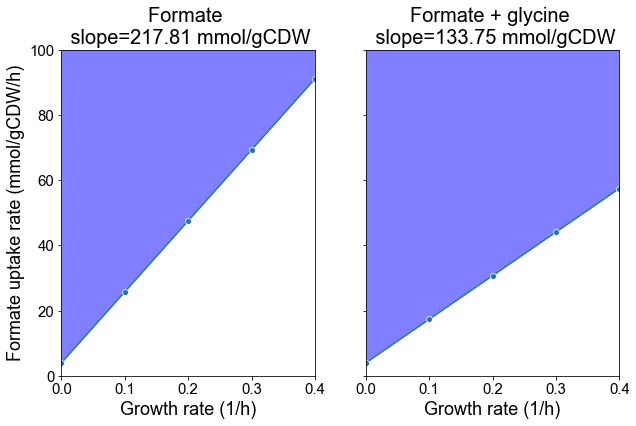

In [15]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,6))

sns.lineplot(
    x='Growth rate',y='Formate uptake',data=FA,
    ax=ax[0],marker='o',
)
ax[0].fill_between(
    x=FA['Growth rate'],y1=100,y2=FA['Formate uptake'],
    facecolor='b', alpha=0.5
)

sns.lineplot(
    x='Growth rate',y='Formate uptake',data=FA_G,
    ax=ax[1],marker='o',
)
ax[1].fill_between(
    x=FA_G['Growth rate'],y1=100,y2=FA_G['Formate uptake'],
    facecolor='b', alpha=0.5
)

plt.setp(
    ax,xlim=(0,0.4),ylim=(0,100),
    xlabel='Growth rate (1/h)',
    ylabel='Formate uptake rate (mmol/gCDW/h)'
)
ax[0].set_title(f'Formate \n slope={slope_FA:.2f} mmol/gCDW')
ax[1].set_title(f'Formate + glycine \n slope={slope_FA_G:.2f} mmol/gCDW')
plt.savefig('Formate dependency.png')

In [16]:
ratio = slope_FA/slope_FA_G
print(f'Formate only condition needs at least {ratio:.2f} times higher formate uptake than formate + glycine.')

Formate only condition needs at least 1.63 times higher formate uptake than formate + glycine.
